<a href="https://colab.research.google.com/github/picazio/COVID19-Studies/blob/master/R0_Lombardia_fit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://books.google.ch/books?hl=it&lr=&id=HT0--xXBguQC&oi=fnd&pg=PA27&dq=Anderson+R.M+May+R.M+Infectious+diseases+of+humans:+dynamics+and+control+1991+Oxford+University+Press+Oxford,+UK+&ots=IdodQMXOdl&sig=Q2B_WIEZF9aD5oUujKEkIzEvT_I&redir_esc=y#v=onepage&q&f=false

Chapter 2

General imports

In [0]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib inline


Epidemic shape function

In [0]:
#function definition
def epidemicshape(x,initInfected,Ntot,Vul,durationOfDisease,initR0) :
    
    b=((initR0*(float(Vul)/float(Ntot)))-1.)/durationOfDisease
    infected=initInfected*np.exp(b*x)
    
    return infected 

Region initial parameters

In [0]:
regione="Lombardia"

end=365*0.6
#end=26
c=1100
#pred_x = list(range(0,int(end)))

initInfected=6.
durationOfDisease=9.
Ntot=10400000.
Mortality=0.1

error=0.02

lockdown_shift=0

Ntot=Mortality*Ntot

Definition of the full model function

In [0]:
def epidemic(initInfected_,Ntot_,durationOfDisease_,initR0,firstR0,secondR0,firstDay,secondDay,gap,pred_x) :

    vulnerables=Ntot_
    initialVulnerables=Ntot_
        
    infecteds=[]
    increment=[]
    exponent=[]
    effectiveR=[]
       
    for x in pred_x :
        
        r0fun=initR0
        initInf=initInfected_
        if x>firstDay :
            initInf=infecteds[firstDay-gap]
            r0fun=firstR0 
            
        if x>secondDay :
            initInf=infecteds[secondDay-gap]
            r0fun=secondR0
       
        infected=epidemicshape(x,initInf,Ntot_,vulnerables,durationOfDisease_,r0fun)
        vulnerables=vulnerables-infected
        infecteds.append((initialVulnerables-vulnerables))
        increment.append(infected)
        
    return infecteds

Now let's try to implement the fit to the data using the model we just implemented


In [0]:
#Create the df
url = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv"
df = pd.read_csv(url)

df=df[df['denominazione_regione']==regione]
df = df.loc[:,['data','deceduti']]
df['poisson_error']=df['deceduti'].apply(lambda x: np.sqrt(x))
#df['death_on_ti']=df['deceduti']/df['terapia_intensiva']

#df.head(55)

In [6]:
FMT = '%Y-%m-%dT%H:%M:%S'
date = df['data']
print(datetime.strptime("2020-01-01T00:00:00", FMT))
df['data'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01T00:00:00", FMT)).days  )

#df.head(50)

2020-01-01 00:00:00


We need to define a function that can actually be fit to the data

In [0]:
day=df.shape[0]
pred_x = list(range(0,day))

Actual fitting section

In [8]:
#parameters ranges
bestR0=2.55
bestfirstR0=1.32
bestsecondR0=0.68
bestfirstDay=26
bestsecondDay=33
bestgap=15

r0Steps=0.01


#lists
initR0s=list(np.arange(bestR0*(1-0.05),bestR0*(1+0.05),r0Steps*1))
firstR0s=list(np.arange(bestfirstR0*(1-0.1),bestfirstR0*(1+0.2),r0Steps*1))
secondR0s=list(np.arange(bestsecondR0*(1-0.3),bestsecondR0*(1+0.3),r0Steps*1))
firstDays=list(np.arange(bestfirstDay-3,bestfirstDay+3,1))
secondDays=list(np.arange(bestsecondDay-3,bestsecondDay+3,1))
gaps=list(np.arange(bestgap-3,bestgap+3,1))
nloops=len(initR0s)*len(firstR0s)*len(secondR0s)*len(firstDays)*len(secondDays)*len(gaps)
print(nloops)
print(initR0s)
print(firstR0s)
print(secondR0s)
print(firstDays)
print(secondDays)
print(gaps)

9210240
[2.4225, 2.4324999999999997, 2.4424999999999994, 2.4524999999999992, 2.462499999999999, 2.472499999999999, 2.4824999999999986, 2.4924999999999984, 2.502499999999998, 2.512499999999998, 2.5224999999999977, 2.5324999999999975, 2.5424999999999973, 2.552499999999997, 2.562499999999997, 2.5724999999999967, 2.5824999999999965, 2.5924999999999963, 2.602499999999996, 2.612499999999996, 2.6224999999999956, 2.6324999999999954, 2.642499999999995, 2.652499999999995, 2.6624999999999948, 2.6724999999999945]
[1.1880000000000002, 1.1980000000000002, 1.2080000000000002, 1.2180000000000002, 1.2280000000000002, 1.2380000000000002, 1.2480000000000002, 1.2580000000000002, 1.2680000000000002, 1.2780000000000002, 1.2880000000000003, 1.2980000000000003, 1.3080000000000003, 1.3180000000000003, 1.3280000000000003, 1.3380000000000003, 1.3480000000000003, 1.3580000000000003, 1.3680000000000003, 1.3780000000000003, 1.3880000000000003, 1.3980000000000004, 1.4080000000000004, 1.4180000000000004, 1.4280000000

In [0]:
def testing(initInfected_,Ntot_,durationOfDisease_,pred_x, in_r0,fr_r0,sd_r0,fr_day,sd_day,Gap,df) :
    #if (in_r0<0 or fr_r0<0 or sd_r0<0) :
    #    return 10000,-1,0
    #else :
        inf=epidemic(initInfected_,Ntot_,durationOfDisease_,in_r0,fr_r0,sd_r0,fr_day,sd_day,Gap,pred_x)
        df['infecteds']=inf
        df['scarti_w']=(df['deceduti']-df['infecteds'])*(df['deceduti']-df['infecteds'])/(df['poisson_error']+0.01)
        df['scarti']=(df['infecteds']-df['deceduti'])/df['deceduti']
        df['incrementi_dec']=df['deceduti'].diff()
        df['incrementi_inf']=df['infecteds'].diff()
        df['scarti_incrementi']=df['incrementi_inf']-df['incrementi_dec']
        #result[df['scarti_w'].sum()]=[in_r0,fr_r0,sd_r0,fr_day,sd_day,Gap]
    
        #return df['scarti_w'].sum(),df['scarti'].sum(),df['scarti'].sum()/abs(df['scarti'].sum())
        #return df['scarti_w'].sum(),(df['infecteds'].sum()-df['deceduti'].sum())/df['deceduti'].sum(),df['scarti'].sum()/abs(df['scarti'].sum())
        #return df['scarti_w'].sum(),df['scarti_incrementi'].sum(),df['scarti'].sum()/abs(df['scarti'].sum())
        return df['scarti_w'].sum()
    
    
    
    

Now the actual loop of loops

In [10]:
'''
#results={}
loop=0
min=10000000000
minPars=[]
for in_r0 in initR0s :
    for fr_r0 in firstR0s :
        for sd_r0 in secondR0s :
            for fr_day in firstDays :
                for sd_day in secondDays :
                    for Gap in gaps :
                        #par,_=testing(initInfected,Ntot,durationOfDisease,pred_x, in_r0,fr_r0,sd_r0,fr_day,sd_day,Gap,df)
                        par=testing(initInfected,Ntot,durationOfDisease,pred_x, in_r0,fr_r0,sd_r0,fr_day,sd_day,Gap,df)

                        if par<min :
                            min=par
                            minPars=[in_r0,fr_r0,sd_r0,fr_day,sd_day,Gap]
                        
                        loop=loop+1
                        if loop%10000==0 :
                            print(loop)
                            print(min)
                            print(minPars)
'''                        

'\n#results={}\nloop=0\nmin=10000000000\nminPars=[]\nfor in_r0 in initR0s :\n    for fr_r0 in firstR0s :\n        for sd_r0 in secondR0s :\n            for fr_day in firstDays :\n                for sd_day in secondDays :\n                    for Gap in gaps :\n                        #par,_=testing(initInfected,Ntot,durationOfDisease,pred_x, in_r0,fr_r0,sd_r0,fr_day,sd_day,Gap,df)\n                        par=testing(initInfected,Ntot,durationOfDisease,pred_x, in_r0,fr_r0,sd_r0,fr_day,sd_day,Gap,df)\n\n                        if par<min :\n                            min=par\n                            minPars=[in_r0,fr_r0,sd_r0,fr_day,sd_day,Gap]\n                        \n                        loop=loop+1\n                        if loop%10000==0 :\n                            print(loop)\n                            print(min)\n                            print(minPars)\n'

In [0]:
#print(minPars)

In [0]:
minPars=[2.5424999999999973, 1.3180000000000003, 0.7160000000000002, 24, 35, 15]
#minPars=[2.5424999999999973, 1.3180000000000003, 0.2160000000000002, 24, 35, 15]

def epidemic_incr(initInfected_,Ntot_,durationOfDisease_,initR0,firstR0,secondR0,firstDay,secondDay,gap,pred_x) :

    vulnerables=Ntot_
    initialVulnerables=Ntot_
        
    infecteds=[]
    increment=[]
    exponent=[]
    effectiveR=[]
       
    for x in pred_x :
        
        r0fun=initR0
        initInf=initInfected_
        if x>firstDay :
            initInf=infecteds[firstDay-gap]
            r0fun=firstR0 
            
        if x>secondDay :
            initInf=infecteds[secondDay-gap]
            r0fun=secondR0
       
        infected=epidemicshape(x,initInf,Ntot_,vulnerables,durationOfDisease_,r0fun)
        vulnerables=vulnerables-infected
        infecteds.append((initialVulnerables-vulnerables))
        increment.append(infected)
        
    return infecteds,increment

In [0]:
x = list(df.iloc[:,0]-54)
y = list(df.iloc[:,1])
yerror = list(df.iloc[:,1]*0.1)

#print(x)
#print(y)

pred_x = list(range(0,400))

shifted_pred=[]
for pred in pred_x :
    shifted_pred.append(pred)

error=0.02    
infec,increm=epidemic_incr(initInfected,Ntot,durationOfDisease,minPars[0],minPars[1],minPars[2],minPars[3],minPars[4],minPars[5],pred_x)
infecUP,incremUP=epidemic_incr(initInfected,Ntot,durationOfDisease,minPars[0]*(1+error),minPars[1]*(1+error),minPars[2]*(1+error),minPars[3]+1,minPars[4]+1,minPars[5]+1,pred_x)
infecDW,incremDW=epidemic_incr(initInfected,Ntot,durationOfDisease,minPars[0]*(1-error),minPars[1]*(1-error),minPars[2]*(1-error),minPars[3]-1,minPars[4]-1,minPars[5]-1,pred_x)

Plotting

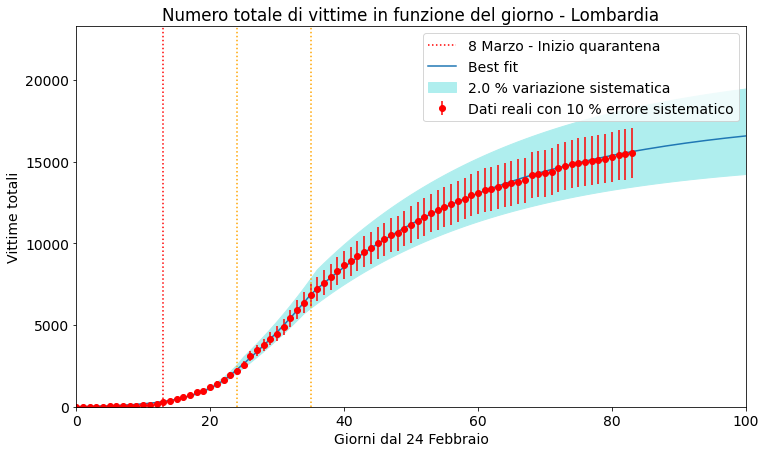

In [14]:
#pred_x = list(range(max(x),sol))
plt.rcParams['figure.figsize'] = [12, 7]
plt.rc('font', size=14)
 
plt.axvline(27-14, 0, 1,label='8 Marzo - Inizio quarantena',linestyle=':', color='red')
plt.errorbar(x,y,yerr=yerror,label="Dati reali con 10 % errore sistematico",color="red",fmt='o')
 
errorUp=np.array(infecUP)
errorDw=np.array(infecDW)
yPred=np.array(infec)
 
#plt.plot(shifted_pred,infecteds[2.50],label="R0 = 2.5 senza contenimento",linestyle='--')
#plt.plot(shifted_pred,infecteds[2.25],label="R0 $\gtrapprox$ 1 - Zona di transizione dal 21-29 Marzo",linestyle='--')
plt.plot(shifted_pred,infec,label="Best fit")
plt.fill_between(shifted_pred, yPred-(yPred-errorDw), yPred+(errorUp-yPred),color="paleturquoise",label=str(error*100)+" % variazione sistematica")
#plt.axvline(27-14, 0, 1,label='8 Marzo - Inizio quarantena',linestyle=':', color='red')
#plt.axvline(26, 0, 1,linestyle=':',color='orange')
#plt.axvline(33, 0, 1,linestyle=':',color='orange')
plt.axvline(minPars[3], 0, 1,linestyle=':',color='orange')
plt.axvline(minPars[4], 0, 1,linestyle=':',color='orange')
 
plt.legend()
plt.title("Numero totale di vittime in funzione del giorno - "+regione)
plt.xlabel("Giorni dal 24 Febbraio")
plt.ylabel("Vittime totali")
#plt.text(10, 3000, 'Grafico 4', fontdict=font)
 
#plt.ylim(3000,8000)
#plt.xlim(20,32)
#plt.grid()
plt.ylim(0,y[-1]*1.5)
plt.xlim(0,100)
#plt.yscale("log")
 
plt.savefig('R02p5_vs_realData_contenimento_'+regione+'.png')
plt.show()

In [0]:
limit=df.shape[0]
df['infecteds']=infec[:limit]
#print(df['infecteds'].pct_change())

dfnew=df.loc[:,['data','deceduti','infecteds']]
dfnew['scarti']=dfnew['deceduti']-dfnew['infecteds']
dfnew['scarti_perc']=(dfnew['deceduti']-dfnew['infecteds'])*100/dfnew['deceduti']
dfnew['incrementi']=dfnew['deceduti'].diff()

Scarti percentuali

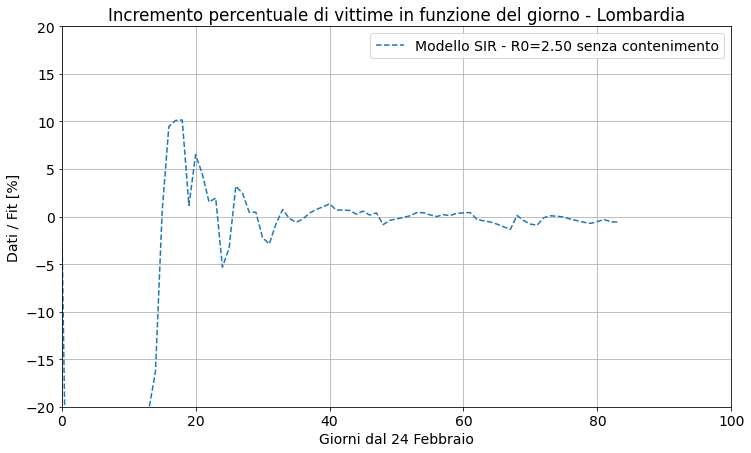

In [16]:
plt.rcParams['figure.figsize'] = [12, 7]
plt.rc('font', size=14)
 
plt.plot(dfnew['data']-54,dfnew['scarti_perc'],label="Modello SIR - R0=2.50"+" senza contenimento",linestyle='--')
 
plt.legend()
plt.title("Incremento percentuale di vittime in funzione del giorno - "+regione)
plt.xlabel("Giorni dal 24 Febbraio")
plt.ylabel("Dati / Fit [%]")
#plt.text(10, 3000, 'Grafico 4', fontdict=font)
 
#plt.ylim(3000,8000)
#plt.xlim(20,32)
plt.grid()
plt.ylim(-20,20)
plt.xlim(0,100)
 
#plt.savefig('R02p5_incrementipercentuali_up200_'+regione+'.png')
plt.show()

Daily increase

[nan, 3.0, 0.0, 5.0, 3.0, 6.0, 1.0, 14.0, 17.0, 18.0, 25.0, 37.0, 19.0, 113.0, 66.0, 135.0, 149.0, 127.0, 146.0, 76.0, 252.0, 202.0, 220.0, 319.0, 209.0, 381.0, 546.0, 361.0, 320.0, 402.0, 296.0, 387.0, 541.0, 542.0, 416.0, 458.0, 381.0, 394.0, 367.0, 351.0, 345.0, 249.0, 297.0, 282.0, 238.0, 300.0, 216.0, 273.0, 110.0, 280.0, 241.0, 235.0, 231.0, 243.0, 199.0, 163.0, 163.0, 203.0, 161.0, 200.0, 166.0, 163.0, 56.0, 124.0, 126.0, 104.0, 93.0, 88.0, 329.0, 42.0, 63.0, 95.0, 222.0, 134.0, 94.0, 85.0, 62.0, 68.0, 62.0, 69.0, 111.0, 115.0, 39.0, 69.0]
72.72136865240124
17841.041777702398


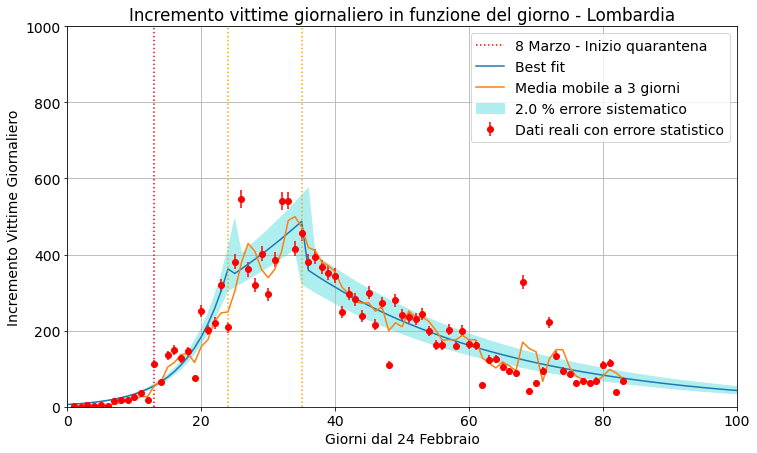

In [17]:
plt.rcParams['figure.figsize'] = [12, 7]
plt.rc('font', size=14)
 
xaxis=np.array(pred_x)
 
errorUp=np.array(incremUP)
errorDw=np.array(incremDW)
yPred=np.array(increm)
 
x = list(dfnew.iloc[:,0]-54)
y = list(dfnew.iloc[:,5])
yerror = list(np.sqrt(dfnew.iloc[:,5]))
 
#print(x)
print(y)
 
plt.axvline(27-14, 0, 1,label='8 Marzo - Inizio quarantena',linestyle=':', color='red')
 
plt.errorbar(x,y,yerr=yerror,label="Dati reali con errore statistico",color="red",fmt='o')
 
plt.plot(xaxis,increm,label="Best fit")
 
plt.fill_between(xaxis, yPred-(yPred-errorDw), yPred+(errorUp-yPred),color="paleturquoise",label=str(error*100)+" % errore sistematico")
plt.plot(x,list(dfnew.iloc[:,5].rolling(3).sum()/3.), label='Media mobile a 3 giorni')
 
#for r0 in initR0 :
#    if r0==2.25 :
#            plt.plot(pred_x,increment[r0],label="R0=2.5 senza contenimento")
#    else :
#            plt.plot(pred_x,increment[r0],label="Incremento R0="+str(r0)+" con contenimento da giorno 30")
#plt.plot(pred_x,increment[1.00],label="Incremento R0=1.00")
 
#plt.plot(pred_x,increment,label="Incremento R0=2.5",color="blue")
plt.legend()
plt.title("Incremento vittime giornaliero in funzione del giorno - "+regione)
plt.xlabel("Giorni dal 24 Febbraio")
plt.ylabel("Incremento Vittime Giornaliero")
#plt.ylim(0,2000)
plt.axvline(minPars[3], 0, 1,linestyle=':',color='orange')
plt.axvline(minPars[4], 0, 1,linestyle=':',color='orange')
 
#plt.xlim(0,200)
plt.ylim(0,1000)
plt.xlim(0,100)
plt.grid()
 
plt.savefig('IncrementoVittime_Vs_R0_contenimento_'+regione+'.png')
 
print(increm[day])
print(infec[300])
 
plt.show()